# Deep Learning- Predict Product Demand
---

## 1. Problem

When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest.
Details like:

![image](image.png)

And, even with an optimized product listing, demand for a product may simply not exist–frustrating sellers who may have over-invested in marketing.

Websites for classified advertisements such as Craigslist are deeply familiar with this problem. Sellers may not make the most out of their listings. When a listing has little demand, it may be due to listing deficiencies (bad images, or bad description) or to the product itself (item not historically in demand). On the other hand, a listing with high demand might be underpriced, meaning less profit for the seller.

## 2. Solution

I propose a neural network model that predicts demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. This model would inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

## 3. Use Case

This prediction can be used to inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive. Some online retailers already have implementations of similar models to make suggestions that help sellers. 

Ebay is a notable example of a similar implementation, which gives the seller an "Average Price Range". However, Ebay's implementation only relies on the product title, and only works for common items with plenty of demand such as iPhones and other popular products. The model proposed here would take into account the quality of the images uploaded and the quality of the product description in addition to the context and historical demand for similar products in the platform.

>*An implementation like this is equal to Craigslist on steroids.*

## 4. Data

Avito is a Russian classified advertisements platform similar to Craigslist. They released a dataset including listings with fields such as title, description, location(city & region), price and images. The target variable is the Deal Probability, which is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one. In addition, there is supplemental historical data on every listing ID which shows the dates every ad was active on the site.

# 5. Short EDA

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cyrtranslit


In [22]:
train = pd.read_csv("https://onedrive.live.com/download?cid=62B3CEE436FDB342&resid=62B3CEE436FDB342%21107&authkey=AEh-8Y6p9SC7FK0",
                      compression='zip', parse_dates=["activation_date"])
test = pd.read_csv("https://onedrive.live.com/download?cid=62B3CEE436FDB342&resid=62B3CEE436FDB342%21106&authkey=AAF_zwBmWjNhNGQ",
                      compression='zip', parse_dates=["activation_date"])

In [23]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


## Distribution of Target

>There's about a million listings with zero demand, and a much smaller number with varying chance of selling.

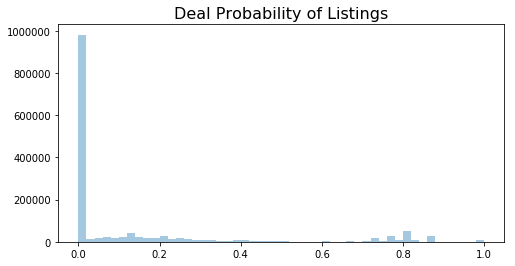

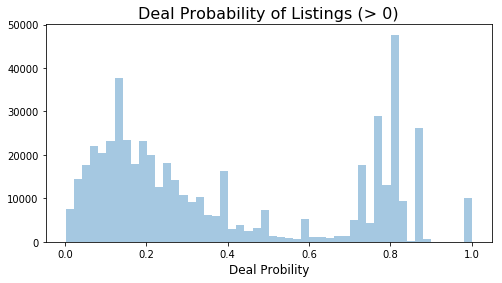

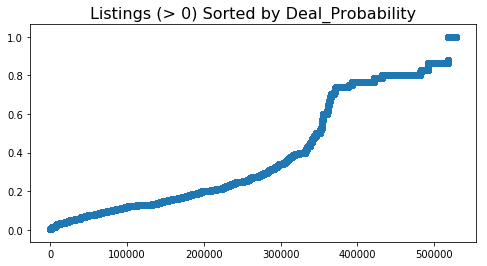

In [24]:
# Define deal probabilities and those over zero
probs = train["deal_probability"].values
probs_no0 = probabilities[probabilities>0]

# Plot probability histogram
plt.figure(figsize=(8,4))
sns.distplot(probs, kde=False)
plt.title("Deal Probability of Listings", fontsize=16)
plt.show()

# Probabilities > 0 hist
plt.figure(figsize=(8,4))
sns.distplot(probs_no0, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability of Listings (> 0)", fontsize=16)
plt.show()

# Scatter of sorted probs
plt.figure(figsize=(8,4))
plt.scatter(range(probs_no0.shape[0]), np.sort(probs_no0))
plt.title("Listings (> 0) Sorted by Deal_Probability", fontsize=16)
plt.show()

## Listings by Region

First let's translate the regions from Russian using the `cyrtranslit` package. Then visualize the distribution of each region.

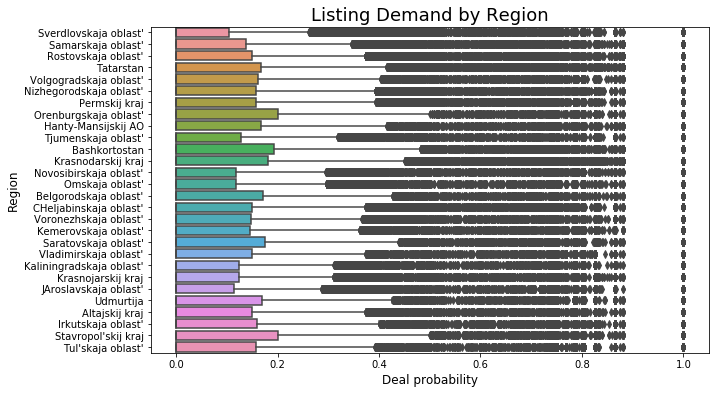

In [116]:
# Get unique regions in cyrilic
cyrilic_regs = train.region.unique().tolist()
# Get unique translations
latin_regs = [cyrtranslit.to_latin(reg,'ru') for reg in cyrilic_regs]

# Put regions in a dictionary
reg_dict = {}
for cyr, lat in zip(cyrilic_regs,latin_regs):
    reg_dict[cyr]=lat
    
# Create a translated list of each region in the dataset
en_list = []
for reg in train.region:
    en_list.append(reg_dict[reg])

# Add english list as column
train['region_en'] = en_list

# Plot 
plt.figure(figsize=(10,6))
sns.boxplot(x="deal_probability", y="region_en", data=train)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Listing Demand by Region",fontsize=18)
plt.show()